<a href="https://colab.research.google.com/github/mgontarz20/PhUnwr_CNN/blob/master/PanelSterowaniaGC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library Imports


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/BadaniaMchtr')
import numpy as np
import os
import tqdm
from tqdm import tqdm
from keras.losses import MeanSquaredError, SparseCategoricalCrossentropy
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import img_to_array, load_img
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.layers import Input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard,CSVLogger,LambdaCallback
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
from keras.models import load_model
from keras import backend as K
import json


#User Imports

In [ ]:
import genConfig
import plotter
import UNetResNet_5lvl_softmax_withReg
import cleanup

# Definition of hyperparameters

In [ ]:
test_size = 0.2
random_state = 2
n_filters = 4
stop_patience = 8
batch_size = 8
epoch_limit = 200
norm = False
coeff = 1.0
if norm:
    coeff = 255.0
activation_function = 'relu'
state = 'new'
metrics = ['accuracy']

#Name definition



In [ ]:
date = datetime.now().strftime("%m-%d-%Y_%H-%M-%S")
root = '/content/drive/MyDrive/BadaniaMchtr/'
pathtoDataSet = f"{root}Datasets/"
dataset = "dataset7_10k_notrandresc"
type1 = "resc_wrpd"
type2 = "wrpd_count"
comment = "SOFTMAX_WrapCount_Regularization"


# Custom Functions (Callbacks, Loss)

In [ ]:
def DiceLoss(targets, inputs, smooth=1e-6):
    
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    intersection = K.sum(K.dot(targets, inputs))
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice

def IoULoss(targets, inputs, smooth=1e-6):
    
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    intersection = K.sum(K.dot(targets, inputs))
    total = K.sum(targets) + K.sum(inputs)
    union = total - intersection
    
    IoU = (intersection + smooth) / (union + smooth)
    return 1 - IoU
  
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

def SSIMLoss(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 255.0))

def SSIM_MSE(y_true, y_pred):
  return mean_squared_error(y_true, y_pred)/SSIMLoss(y_true, y_pred)

In [ ]:
callbacks = [
    EarlyStopping(patience=stop_patience, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0000001, verbose=1),
    ModelCheckpoint(f'{root}Results/{name}/model/{name}.h5', verbose=1, save_best_only=True),
    #Tensordash(ModelName=f"{name}", email='mgontarz15@gmail.com', password='dupadupa'),
    TensorBoard(log_dir=f"{root}Results/{name}/logs", write_graph=True, write_images= True, update_freq=5),
    CSVLogger(f"{root}Results/{name}/csv/{name}.csv"),
    #json_logging_callback,
            ]

#Importing Images

In [ ]:
X = np.load(f"{root}Datasets/X_{dataset}.npy")
y = np.load(f"{root}Datasets/w_{dataset}.npy").astype(np.uint8)


num_classes = int((np.amax(y) - np.amin(y)) +1)
print(X.shape, y.shape)
print(X.dtype, y.dtype)
print(num_classes)
name = f"UNetResNet5_{type1}_{date}_{comment}_{str(num_classes)}"

In [ ]:
genConfig.write_cfg(cfg_dir, name, 'w', type_input = type1, type_output= type2, dataset = dataset, classes = num_classes)

del type1
del type2
del dataset

# Path Definition
# Folder Generation

In [ ]:

cleanup.clearEmptyDirectories("/content/drive/MyDrive/BadaniaMchtr/Results")
os.makedirs(f'{root}Results/{name}', exist_ok=True)
os.makedirs(f'{root}Results/{name}/model', exist_ok=True)
os.makedirs(f'{root}Results/{name}/cfg', exist_ok=True)
os.makedirs(f'{root}Results/{name}/csv', exist_ok=True)
os.makedirs(f'{root}Results/{name}/logs', exist_ok=True)
cfg_dir = f'{root}Results/{name}/cfg'

Cleaning up results directory

No folders removed!


# Train Test Splitting


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=random_state)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
del X
del y

(6400, 256, 256, 1) (1600, 256, 256, 1) (6400, 256, 256, 1) (1600, 256, 256, 1)


In [ ]:
genConfig.write_cfg(cfg_dir, name, "a", test_size = test_size, random_state = random_state)
del test_size
del random_state

#Model Loading and Initialization

In [ ]:
input_img = Input((256, 256, 1), name='img')
model = UNetResNet_5lvl_softmax_withReg.get_unet(input_img, num_classes, kernel_regularizer = 'l2')
#model = load_model("/content/drive/MyDrive/BadaniaMchtr/Results/QPI_DPI_Net_resc_wrpd_11-02-2021_18-07-57_QPIDPI_MSE-SSIM/model/QPI_DPI_Net_resc_wrpd_11-02-2021_18-07-57_QPIDPI_MSE-SSIM.h5")
model.compile(optimizer=Adam(learning_rate=0.0001, epsilon=1e-07), loss=SparseCategoricalCrossentropy(),  metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  80          ['img[0][0]']                    
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
genConfig.write_cfg(cfg_dir,name, 'a', optimizer = "Adam", loss = comment, metrics = metrics, state = state, n_filters = n_filters)
del n_filters
del state


#Model Fitting

In [ ]:
start = datetime.now()
results = model.fit(X_train, y_train, batch_size=batch_size, epochs=epoch_limit, callbacks=callbacks,
                     validation_data=(X_valid, y_valid))

stop = datetime.now()



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/200
800/800 [==============================] - ETA: 0s - loss: 2.1560 - accuracy: 0.1538
Epoch 00001: val_loss improved from inf to 1.98280, saving model to /content/drive/MyDrive/BadaniaMchtr/Results/UNetResNet5_resc_wrpd_11-13-2021_16-31-46_SOFTMAX_WrapCount/model/UNetResNet5_resc_wrpd_11-13-2021_16-31-46_SOFTMAX_WrapCount.h5
800/800 [==============================] - 248s 264ms/step - loss: 2.1560 - accuracy: 0.1538 - val_loss: 1.9828 - val_accuracy: 0.3259 - lr: 1.0000e-04
Epoch 2/200
800/800 [==============================] - ETA: 0s - loss: 1.5657 - accuracy: 0.5089
Epoch 00002: val_loss improved from 1.98280 to 1.18423, saving model to /content/drive/MyDrive/BadaniaMchtr/Results/UNetResNet5_resc_wrpd_11-13-2021_16-31-46_SOFTMAX_WrapCount/model/UNetResNet5_resc_wrpd_11-13-2021_16-31-46_SOFTMAX_WrapCount.h5
800/800 [==============================] - 211s 264ms/step - loss: 1.5657 - accuracy: 0.5089 - val_loss: 1.1842 - val_accuracy: 0.6877 - lr: 1.0000e-04
Epoch 3/200
800/

In [ ]:
time = stop - start
del stop
del start

In [ ]:
genConfig.write_cfg(cfg_dir,name, "a", batch_size = batch_size, epoch_limit = epoch_limit, time = time, activation_function = activation_function)
del epoch_limit
del time

#Plotting Results

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.500496 to fit



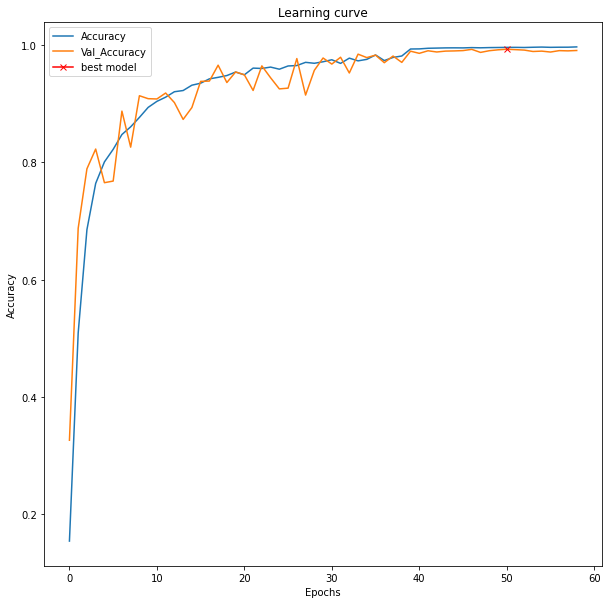

In [ ]:
plotter.plot_model_data(model, name, results, root)
genConfig.write_cfg(cfg_dir,name, "a",  best_loss = np.min(results.history["val_loss"]), for_epoch_loss = np.argmin(results.history["val_loss"]), best_acc = np.max(results.history["val_accuracy"]), for_epoch_acc = np.argmax(results.history["val_accuracy"]))
del results

#Model Evaluation

In [ ]:
score = model.evaluate(X_train, y_train,
                            batch_size=batch_size)
labels = model.metrics_names

header_train  = "\n-------TRAIN EVALUATION-------"
loss_list = []


for i, loss in enumerate(labels):
    loss_list.append(f"| {loss} : {score[i]} |")

genConfig.write_cfg(cfg_dir,name, "a", _ = header_train, TRAIN_EVAL = "".join(loss_list))

loss_list.clear()

800/800 [==============================] - 64s 80ms/step - loss: 0.0113 - accuracy: 0.9971


In [ ]:
score= model.evaluate(X_valid, y_valid,
                            batch_size=batch_size)

header_test = "\n-------TEST EVALUATION-------"

for i, loss in enumerate(labels):
    loss_list.append(f"| {loss} : {score[i]} |")

genConfig.write_cfg(cfg_dir,name, "a", _ = header_test, TEST_EVAL = "".join(loss_list))


del score

del header_test
#del header_train

#del labels

200/200 [==============================] - 22s 111ms/step - loss: 0.0278 - accuracy: 0.9911


In [ ]:
!apt-get install rar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  rar
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 295 kB of archives.
After this operation, 799 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 rar amd64 2:5.5.0-1 [295 kB]
Fetched 295 kB in 0s (2,945 kB/s)
Selecting previously unselected package rar.
(Reading database ... 155219 files and directories currently installed.)
Preparing to unpack .../rar_2%3a5.5.0-1_amd64.deb ...
Unpacking rar (2:5.5.0-1) ...
Setting up rar (2:5.5.0-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
name = "UNetResNet5lvl_resc_wrpd_10-14-2021_22-11-02_SSIMloss"
!rar a '/content/drive/MyDrive/UNetResNet5_resc_wrpd_11-13-2021_16-31-46_SOFTMAX_WrapCount_Results' '/content/drive/MyDrive/BadaniaMchtr/Results/UNetResNet5_resc_wrpd_11-13-2021_16-31-46_SOFTMAX_WrapCount'
from google.colab import files
files.download("/content/drive/MyDrive/UNetResNet5_resc_wrpd_11-13-2021_16-31-46_SOFTMAX_WrapCount_Results.rar")



RAR 5.50   Copyright (c) 1993-2017 Alexander Roshal   11 Aug 2017
Trial version             Type 'rar -?' for help

Evaluation copy. Please register.

Creating archive /content/drive/MyDrive/UNetResNet5_resc_wrpd_11-13-2021_16-31-46_SOFTMAX_WrapCount_Results.rar

Adding    /content/drive/MyDrive/BadaniaMchtr/Results/UNetResNet5_resc_wrpd_11-13-2021_16-31-46_SOFTMAX_WrapCount/model/UNetResNet5_resc_wrpd_11-13-2021_16-31-46_SOFTMAX_WrapCount.h5       8% 16% 25% 33% 42% 50% 59% 67% 76% 84% 89%  OK 
Adding    /content/drive/MyDrive/BadaniaMchtr/Results/UNetResNet5_resc_wrpd_11-13-2021_16-31-46_SOFTMAX_WrapCount/cfg/UNetResNet5_resc_wrpd_11-13-2021_16-31-46_SOFTMAX_WrapCount.txt      89%  OK 
Adding    /content/drive/MyDrive/BadaniaMchtr/Results/UNetResNet5_resc_wrpd_11-13-2021_16-31-46_SOFTMAX_WrapCount/csv/UNetResNet5_resc_wrpd_11-13-2021_16-31-46_SOFTMAX_WrapCount.csv      89%  OK 
Adding    /content/drive/MyDrive/Badani

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>